In [85]:
import pandas as pd

In [86]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'TSLA'

In [87]:
#last 5 years data with interval of 1 day
data =  pd.read_csv('/home/sayuru/Projects/stock-management/stock-management-backend/assets/uploads/historical_data/'+stock_symbol+'.csv')


In [88]:
type(data)

pandas.core.frame.DataFrame

In [89]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
1,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500
3,2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500
4,2010-07-08,3.228,3.504,3.114,3.492,3.492,38557000


In [90]:
len(data)

2392

In [91]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2387,2019-12-24,83.671997,85.094002,82.538002,85.050003,85.050003,40273500
2388,2019-12-26,85.582001,86.695999,85.269997,86.188004,86.188004,53169500
2389,2019-12-27,87.000000,87.061996,85.222000,86.075996,86.075996,49728500
2390,2019-12-30,85.758003,85.800003,81.851997,82.940002,82.940002,62932000
2391,2019-12-31,81.000000,84.258003,80.416000,83.666000,83.666000,51428500


In [92]:
opn = data[['Open']]

<Axes: >

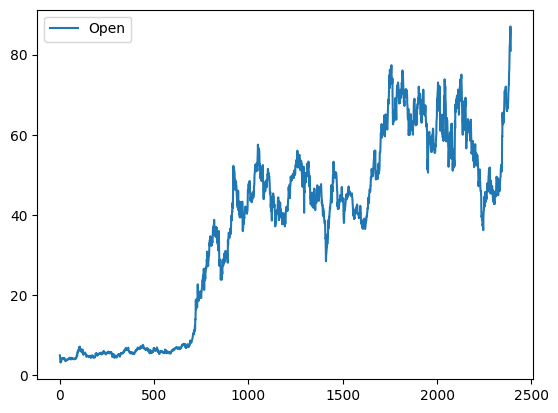

In [93]:
opn.plot()

In [94]:
import matplotlib.pyplot as plt

In [95]:
ds = opn.values

In [96]:
ds

array([[ 5.      ],
       [ 4.6     ],
       [ 4.      ],
       ...,
       [87.      ],
       [85.758003],
       [81.      ]])

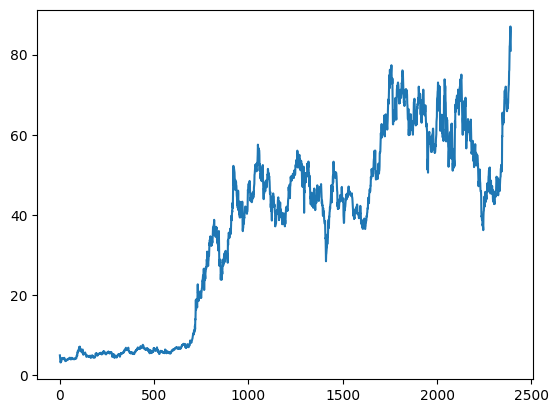

In [97]:
plt.plot(ds)

In [98]:
import numpy as np

In [99]:
from sklearn.preprocessing import MinMaxScaler

In [100]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [101]:
len(ds_scaled), len(ds)

(2392, 2392)

In [102]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [103]:
train_size,test_size

(1674, 718)

In [104]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [105]:
len(ds_train),len(ds_test)

(1674, 718)

In [106]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [107]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [108]:
X_train.shape,y_train.shape

((1573, 100), (1573,))

In [109]:
X_test.shape, y_test.shape

((617, 100), (617,))

In [110]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [111]:
import keras
# from keras.models import Sequential
from keras.layers import Dense, LSTM

In [112]:
#Creating LSTM model using keras
model = keras.Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [113]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0443 - val_loss: 0.0041
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0017 - val_loss: 0.0051
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0011 - val_loss: 0.0065
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0011 - val_loss: 0.0069
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 9.8081e-04 - val_loss: 0.0047
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 9.3565e-04 - val_loss: 0.0069
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 8.9024e-04 - val_loss: 0.0049
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 8.0914e-04 - val_loss: 0.0050
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 8.0052e-04 - val_loss: 0.0032
Epoch 12/100
25/25 ━━━━━━━━━━━━━

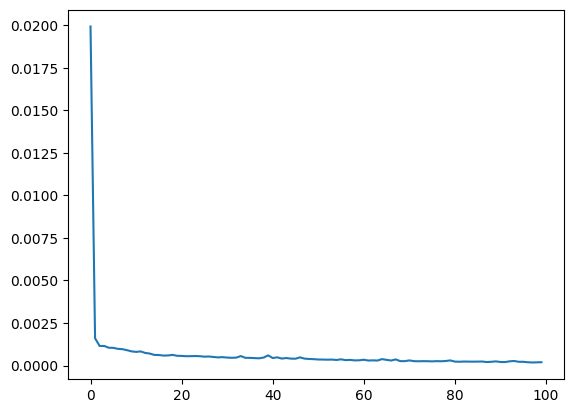

In [114]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [115]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [116]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

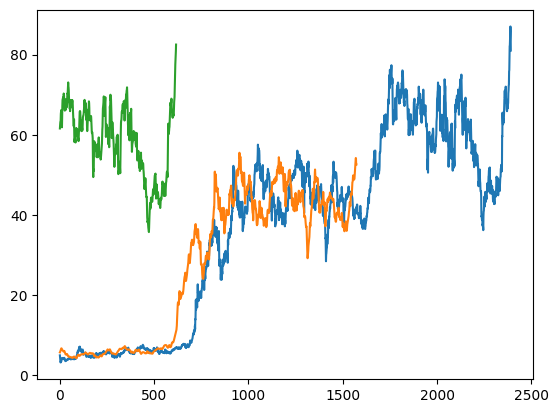

In [117]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [118]:
type(train_predict)

numpy.ndarray

In [119]:
test = np.vstack((train_predict,test_predict))

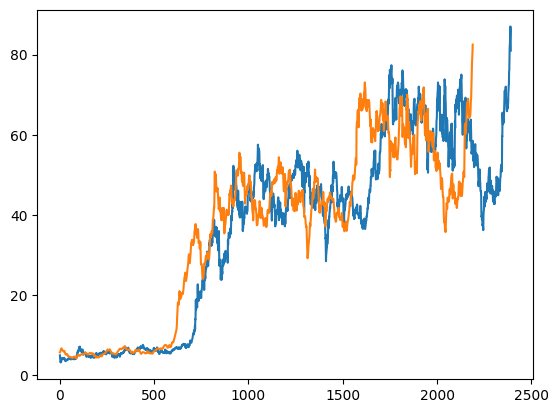

In [120]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [121]:
len(ds_test)

718

In [122]:
#Getting the last 100 days records
fut_inp = ds_test[-100:]

In [123]:
fut_inp = fut_inp.reshape(1,-1)

In [124]:
tmp_inp = list(fut_inp)

In [125]:
fut_inp.shape

(1, 100)

In [126]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()
print(tmp_inp)

[0.5250202812395549, 0.5177147495583249, 0.5077352934154609, 0.5134651315475337, 0.4887552046029699, 0.4787279878718425, 0.49675307978799593, 0.5048942128634865, 0.491500740104092, 0.4933868237597287, 0.4866303657546674, 0.47142244425344987, 0.47653152604688914, 0.47163728930907695, 0.484314556176288, 0.508547032421334, 0.4964427493673303, 0.5031513870983143, 0.4926705820560569, 0.5038915031275365, 0.5105763262187842, 0.5124862722628084, 0.5281956023492336, 0.5528338943799836, 0.5510671584777729, 0.5487752590364321, 0.5403475982428495, 0.546387814544239, 0.5487752590364321, 0.5499450890512342, 0.5344506517690875, 0.5380795611898963, 0.4975886811822566, 0.5121520317051041, 0.5397029914529914, 0.5416129255598529, 0.5380317886644701, 0.5423053168122999, 0.5150169746454661, 0.5144200806952203, 0.5100988277706154, 0.5245905553168122, 0.5376020627417275, 0.5470562956596474, 0.5515207945375542, 0.5533113928281524, 0.5767082199302868, 0.5759681158382274, 0.5881678842572696, 0.5838704937210523,

In [127]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.9026969075202942], [0.8727290630340576], [0.8536375164985657], [0.8401368856430054], [0.829017162322998], [0.8184319138526917], [0.8073000311851501], [0.7951335906982422], [0.7818742990493774], [0.7677059769630432], [0.7529007792472839], [0.7377205491065979], [0.722369372844696], [0.706981897354126], [0.691631555557251], [0.6763482093811035], [0.6611365675926208], [0.6459904909133911], [0.6309047937393188], [0.6158798336982727], [0.6009247899055481], [0.5860587358474731], [0.5713084936141968], [0.5567078590393066], [0.5422953367233276], [0.5281132459640503], [0.5142050981521606], [0.5006147027015686], [0.4873853325843811], [0.4745577871799469]]


In [128]:
len(ds_scaled)

2392

In [129]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

In [130]:
ds_new = ds_scaled.tolist()

In [131]:
len(ds_new)

2392

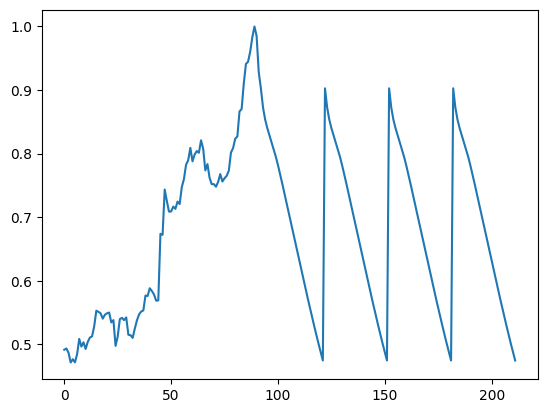

In [137]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[2300:])

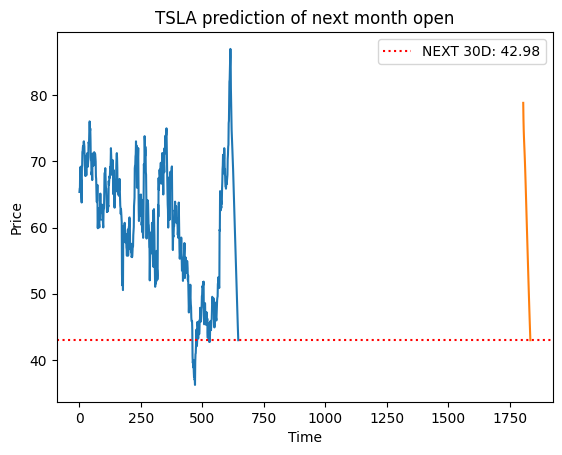

In [133]:
# Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).flatten()  # Flatten the array for plotting

# Calculate the index for plotting the predicted values
start_index = len(ds_scaled) - len(ds_test) + time_stamp + 1  # Starting index for test data
end_index = start_index + len(lst_output)  # Ending index for predicted values

# Plotting final results with predicted value after 30 Days
plt.plot(final_graph[start_index:])  # Plot actual values
plt.plot(np.arange(end_index, end_index + len(lst_output)), normalizer.inverse_transform(lst_output))  # Plot predicted values
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[-1], color='red', linestyle=':', label='NEXT 30D: {0}'.format(round(float(final_graph[-1]), 2)))
plt.legend()
plt.show()

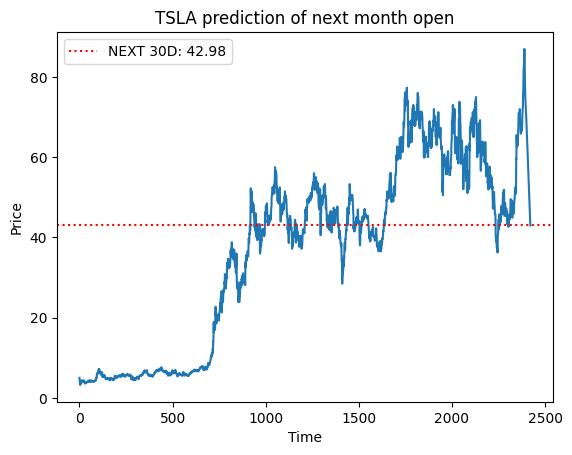

In [134]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[-1], color='red', linestyle=':', label='NEXT 30D: {0}'.format(round(final_graph[-1], 2)))
plt.legend()

